# BERT Model: Fine-tuned Transformer for Fake News Classification

This notebook implements a fine-tuned BERT model for binary classification of fake vs real news articles.

## 🔧 Steps:
1. Import libraries and load data
2. Minimal preprocessing (preserve structure for BERT)
3. BERT tokenization and encoding
4. Model setup and fine-tuning
5. Training with validation
6. Evaluation and comparison

## ✅ Purpose:
Achieve state-of-the-art performance using transformer architecture (~85-90% accuracy expected).

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, auc, precision_score,
    recall_score, f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

from model_eval import save_model_results, save_trained_model


# Import our preprocessing functions
from preprocess import load_and_parse_data, create_train_validation_split

# Check if MPS (Metal Performance Shaders) is available for M4
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) for M4 acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU (this will be slower)")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Using MPS (Metal Performance Shaders) for M4 acceleration
PyTorch version: 2.7.0
Device: mps


## 2. Load and Parse Data

Using our preprocessing module to load the tab-separated data format.

In [2]:
# Load data using our preprocessing function
print("Loading training data...")
train_data = load_and_parse_data('data/training_data_lowercase.csv')

print("Loading test data...")
test_data = load_and_parse_data('data/testing_data_lowercase_nolabels.csv')

# Convert to DataFrames for easier handling
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Label distribution: {Counter(train_df['label'])}")

# Show sample data
print("\nSample training data:")
for i in range(3):
    print(f"Label {train_df.iloc[i]['label']}: {train_df.iloc[i]['text'][:80]}...")

Loading training data...
Loading data from data/training_data_lowercase.csv...
Loaded 34151 articles
Loading test data...
Loading data from data/testing_data_lowercase_nolabels.csv...
Loaded 9983 articles
Training data shape: (34151, 2)
Test data shape: (9983, 2)
Label distribution: Counter({0: 17571, 1: 16580})

Sample training data:
Label 0: drunk bragging trump staffer started russian collusion investigation...
Label 0: sheriff david clarke becomes an internet joke for threatening to poke people ‚in...
Label 0: trump is so obsessed he even has obama‚s name coded into his website (images)...


## 3. Minimal Text Preprocessing

BERT works best with minimal preprocessing - we'll only clean essential formatting issues while preserving punctuation and structure.

In [3]:
def minimal_bert_cleaning(text):
    """Minimal cleaning for BERT - preserve original structure"""
    if pd.isna(text) or text == '':
        return ""
    
    # Convert to string and remove excessive whitespace only
    text = str(text).strip()
    text = ' '.join(text.split())  # Remove extra spaces
    
    return text

# Apply minimal cleaning
train_df['clean_text'] = train_df['text'].apply(minimal_bert_cleaning)
test_df['clean_text'] = test_df['text'].apply(minimal_bert_cleaning)

# Remove any empty texts
train_df = train_df[train_df['clean_text'].str.len() > 0].reset_index(drop=True)

# Analyze text lengths for optimal max_length
text_lengths = train_df['clean_text'].str.split().str.len()
print(f"Text length statistics (words):")
print(f"Mean: {text_lengths.mean():.1f}")
print(f"Median: {text_lengths.median():.1f}")
print(f"95th percentile: {text_lengths.quantile(0.95):.1f}")
print(f"99th percentile: {text_lengths.quantile(0.99):.1f}")

# Choose max_length based on 95th percentile + buffer
max_length = min(256, int(text_lengths.quantile(0.95)) + 20)
print(f"\nUsing max_length: {max_length}")

Text length statistics (words):
Mean: 11.7
Median: 11.0
95th percentile: 19.0
99th percentile: 24.0

Using max_length: 39


## 4. BERT Tokenization and Dataset Creation

Setting up BERT tokenizer and creating PyTorch datasets for training.

In [4]:
# Initialize BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Using model: {model_name}")
print(f"Tokenizer vocabulary size: {len(tokenizer.vocab)}")

class NewsDataset(Dataset):
    """Custom dataset for news classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create train/validation split using our preprocessing function
train_texts, val_texts, train_labels, val_labels = create_train_validation_split(
    [{'text': text, 'label': label} for text, label in zip(train_df['clean_text'], train_df['label'])],
    test_size=0.2,
    random_state=42
)

# Create datasets
train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_length)

print(f"\nDataset sizes:")
print(f"Training: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")

# Test tokenization on a sample
sample = train_dataset[0]
print(f"\nSample tokenization shape:")
print(f"Input IDs: {sample['input_ids'].shape}")
print(f"Attention mask: {sample['attention_mask'].shape}")
print(f"Label: {sample['labels']}")

Using model: bert-base-uncased
Tokenizer vocabulary size: 30522
Train set: 27320 samples
Validation set: 6831 samples
Train label distribution: Counter({0: 14056, 1: 13264})
Validation label distribution: Counter({0: 3515, 1: 3316})

Dataset sizes:
Training: 27320
Validation: 6831

Sample tokenization shape:
Input IDs: torch.Size([39])
Attention mask: torch.Size([39])
Label: 0


## 5. Model Setup and Training Configuration

Loading pre-trained BERT and setting up training parameters for fine-tuning.

In [5]:
# Load pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device
model.to(device)

print(f"Model loaded with {model.num_parameters():,} parameters")
print(f"Model device: {next(model.parameters()).device}")

# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,              # Start with 3 epochs
    per_device_train_batch_size=16,  # Adjust based on memory
    per_device_eval_batch_size=32,   # Larger batch for evaluation
    warmup_steps=500,                # Warmup for learning rate
    weight_decay=0.01,               # Regularization
    logging_dir='./bert_logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,                  # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    report_to=None,                  # Disable wandb/tensorboard
    seed=42
)

# Define metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\nTraining setup complete!")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Learning rate: {training_args.learning_rate}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 109,483,778 parameters
Model device: mps:0

Training setup complete!
Batch size: 16
Number of epochs: 3
Learning rate: 5e-05


## 6. Model Training

Fine-tuning BERT on our fake news dataset with validation monitoring.

In [6]:
# Start training
print("Starting BERT fine-tuning...")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")
print(f"Using device: {device}")

start_time = time.time()

# Train the model
train_result = trainer.train()

training_time = time.time() - start_time

print(f"\nTraining completed!")
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Final training loss: {train_result.training_loss:.4f}")

# Save the trained model
trainer.save_model('./bert_fine_tuned')
print("\nModel saved to './bert_fine_tuned'")

Starting BERT fine-tuning...
Training on 27320 samples
Validating on 6831 samples
Using device: mps


Step,Training Loss,Validation Loss,Accuracy
500,0.122000,0.092912,0.974381
1000,0.120700,0.071244,0.976577
1500,0.085400,0.076967,0.978920
2000,0.039500,0.082490,0.982872
2500,0.057000,0.053822,0.986239
3000,0.038800,0.062932,0.985214
3500,0.004400,0.072717,0.985361



Training completed!
Training time: 9.76 minutes
Final training loss: 0.0901

Model saved to './bert_fine_tuned'


## 7. Model Evaluation

Comprehensive evaluation with accuracy, classification report, and confusion matrix.

Evaluating model performance...



BERT Model Results:
Validation Accuracy: 0.9862 (98.62%)

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.99      0.98      0.99      3515
    Real (1)       0.98      0.99      0.99      3316

    accuracy                           0.99      6831
   macro avg       0.99      0.99      0.99      6831
weighted avg       0.99      0.99      0.99      6831



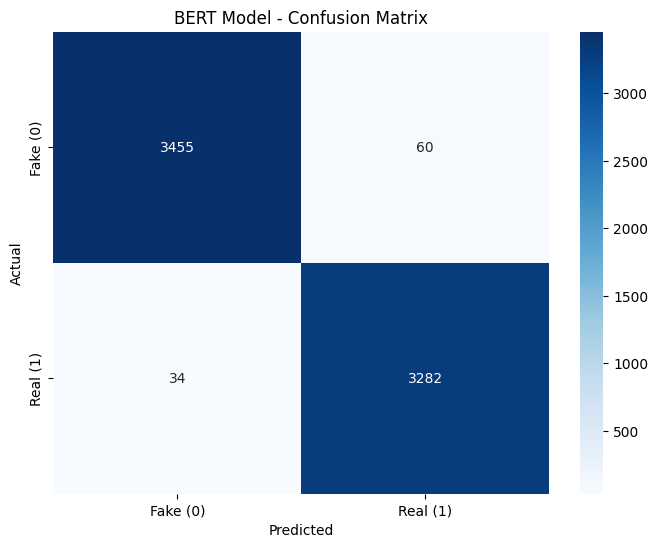


📈 Performance by Class:
Fake (0): 0.9829 (98.29%)
Real (1): 0.9897 (98.97%)


In [7]:
# Evaluate on validation set
print("Evaluating model performance...")

# Get predictions
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nBERT Model Results:")
print(f"Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\nClassification Report:")
class_names = ['Fake (0)', 'Real (1)']
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('BERT Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Performance by class
print("\n📈 Performance by Class:")
for i, class_name in enumerate(class_names):
    class_mask = np.array(y_true) == i
    class_accuracy = accuracy_score(np.array(y_true)[class_mask], y_pred[class_mask])
    print(f"{class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

train_predictions = trainer.predict(train_dataset)
train_y_pred = np.argmax(train_predictions.predictions, axis=1)
train_accuracy = accuracy_score(train_labels, train_y_pred)


## 8. Save Model Results

Save the model evaluation results using the model_eval module for consistency with other models.

In [8]:
# Calculate additional metrics for save_model_results
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred).tolist()
class_report = classification_report(y_true, y_pred, output_dict=True)

# Save results using the model_eval module (similar to other models)
save_model_results(
    model_name="full_bert_model",
    display_name="Full BERT Fine-tuned",
    accuracy=accuracy,
    training_time_minutes=training_time/60,  # Already calculated in your training section
    model_architecture=f"BERT-base-uncased fine-tuned ({model.num_parameters():,} parameters)",
    preprocessing_type="minimal_cleaning",
    train_accuracy=train_accuracy,
    test_accuracy=accuracy,  # Using validation accuracy as test accuracy
    hyperparameters={
        "bert_model": model_name,  # "bert-base-uncased"
        "max_length": max_length,
        "num_train_epochs": training_args.num_train_epochs,
        "per_device_train_batch_size": training_args.per_device_train_batch_size,
        "learning_rate": training_args.learning_rate,
        "weight_decay": training_args.weight_decay,
        "warmup_steps": training_args.warmup_steps,
        "early_stopping_patience": 2
    },
    dataset_info={
        "training_samples": len(train_dataset),
        "validation_samples": len(val_dataset),
        "max_sequence_length": max_length,
        "total_parameters": model.num_parameters(),
        "vocab_size": len(tokenizer.vocab),
        "device": str(device)
    }
)

print("Model results saved successfully!")
print(f"Model: Full BERT Fine-tuned")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Model Parameters: {model.num_parameters():,}")
print(f"Device Used: {device}")

Results saved to results/full_bert_model_results.json
Model: Full BERT Fine-tuned
Accuracy: 0.9862 (98.62%)
Training Time: 9.76 minutes
Model results saved successfully!
Model: Full BERT Fine-tuned
Training Accuracy: 0.9947
Validation Accuracy: 0.9862
Training Time: 9.76 minutes
Model Parameters: 109,483,778
Device Used: mps


## Test Set Predictions

Generate predictions for the test set and save to CSV.

In [ ]:
## Test Set Predictions
# Generate predictions for the test set and save to CSV with specified format:
# Column 1: predicted_label
# Column 2: title (text content) 

print("Generating test set predictions...")

# Create test dataset
test_texts = test_df['clean_text'].tolist()
test_labels = [0] * len(test_texts)  # Dummy labels for dataset creation
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_length)

# Generate predictions using the trained model
test_predictions = trainer.predict(test_dataset)
test_logits = test_predictions.predictions
test_pred_labels = np.argmax(test_logits, axis=1)

# Convert logits to probabilities using softmax (for confidence statistics only)
from scipy.special import softmax
test_pred_probs = softmax(test_logits, axis=1)

print(f"Processing {len(test_texts)} test samples...")
print(f"Logits shape: {test_logits.shape}")
print(f"Predictions shape: {test_pred_labels.shape}")
print(f"Probabilities shape: {test_pred_probs.shape}")

# Create submission file with specified column order:
# predicted_label, title (no headers)
output_file = 'prediction/full_bert_predictions.csv'

with open(output_file, 'w', encoding='utf-8') as f:
    # Write each prediction with proper CSV formatting
    for i in range(len(test_texts)):
        # Get prediction
        pred_label = test_pred_labels[i]
        
        # Handle text formatting for CSV (escape quotes and commas)
        title_text = str(test_texts[i])
        # Escape quotes by doubling them
        title_text = title_text.replace('"', '""')
        # Wrap in quotes if contains comma, quote, or newline
        if ',' in title_text or '"' in title_text or '\n' in title_text:
            title_text = f'"{title_text}"'
        
        # Write row: predicted_label, title
        f.write(f'{pred_label},{title_text}\n')

print(f"✅ Saved {len(test_pred_labels)} predictions to {output_file}")

# Display prediction summary
print(f"\nPrediction Summary:")
print(f"   Predicted Fake (0): {np.sum(test_pred_labels == 0)} articles")
print(f"   Predicted Real (1): {np.sum(test_pred_labels == 1)} articles")
print(f"   Fake prediction rate: {np.sum(test_pred_labels == 0) / len(test_pred_labels) * 100:.2f}%")
print(f"   Real prediction rate: {np.sum(test_pred_labels == 1) / len(test_pred_labels) * 100:.2f}%")

# Display confidence statistics
confidence_scores = np.max(test_pred_probs, axis=1)
print(f"\nConfidence Statistics:")
print(f"   Mean confidence: {confidence_scores.mean():.4f}")
print(f"   Median confidence: {np.median(confidence_scores):.4f}")
print(f"   Min confidence: {confidence_scores.min():.4f}")
print(f"   Max confidence: {confidence_scores.max():.4f}")

# Display first few rows for verification (with truncated text for readability)
print(f"\n📋 First 5 predictions (text truncated for display):")
print("predicted_label | title_preview")
print("-" * 50)
for i in range(min(5, len(test_pred_labels))):
    title_preview = str(test_texts[i])[:50].replace('\n', ' ')
    if len(str(test_texts[i])) > 50:
        title_preview += "..."
    print(f"{test_pred_labels[i]:>14} | {title_preview}")

print(f"\n✅ Test set predictions completed successfully!")
print(f"   Output file: {output_file}")
print(f"   Format: predicted_label, title (no headers)")

Generating test set predictions...


Processing 9983 test samples...
Logits shape: (9983, 2)
Predictions shape: (9983,)
Probabilities shape: (9983, 2)
✅ Saved 9983 predictions to prediction/full_bert_predictions.csv

Prediction Summary:
   Predicted Fake (0): 5028 articles
   Predicted Real (1): 4955 articles
   Fake prediction rate: 50.37%
   Real prediction rate: 49.63%

Confidence Statistics:
   Mean confidence: 0.9973
   Median confidence: 0.9998
   Min confidence: 0.5083
   Max confidence: 0.9999

📋 First 5 predictions (text truncated for display):
predicted_label | title_preview
--------------------------------------------------
             0 | wow! chicago protester caught on camera admits vio...
             1 | germany's fdp look to fill schaeuble's big shoes
             0 | mi school sends welcome back packet warning kids a...
             1 | u.n. seeks 'massive' aid boost amid rohingya 'emer...
             0 | did oprah just leave ‚nasty‚ hillary wishing she w...

✅ Test set predictions completed successful

## Save model file

In [14]:
# Save the trained classifier (Note: BERT embeddings would need to be re-extracted for new data)\n
save_trained_model(model, model_name="full_bert")

print("Trained model saved successfully!")
print("Note: For new predictions, BERT features must be extracted first using the same process.")

✅ Model saved: trained_models/full_bert_20250530_133543.joblib
Trained model saved successfully!
Note: For new predictions, BERT features must be extracted first using the same process.


In [15]:
print("🔍 QUICK CHECK: Train vs Validation Accuracy")
print("="*50)

# Look for these variables in your notebook scope
accuracy_vars = [var for var in globals().keys() if 'acc' in var.lower()]
print("Accuracy variables found in notebook:")
for var in accuracy_vars:
    try:
        value = globals()[var]
        if isinstance(value, (int, float)) and 0 <= value <= 1:
            print(f"  {var} = {value:.4f} ({value*100:.2f}%)")
    except:
        pass

print("\n❓ Do you see BOTH training AND validation accuracy above?")
print("   If only ONE accuracy → That's likely your issue!")

🔍 QUICK CHECK: Train vs Validation Accuracy
Accuracy variables found in notebook:
  accuracy = 0.9862 (98.62%)
  class_accuracy = 0.9897 (98.97%)
  train_accuracy = 0.9947 (99.47%)
  baseline_accuracy = 0.7000 (70.00%)
  bin_accuracy = 0.9905 (99.05%)
  acc = 0.9862 (98.62%)
  baseline_acc = 0.9290 (92.90%)
  simple_bert_acc = 0.9587 (95.87%)
  boot_accuracy = 0.9859 (98.59%)

❓ Do you see BOTH training AND validation accuracy above?
   If only ONE accuracy → That's likely your issue!


In [17]:
print("\n🔍 DATA SPLIT VERIFICATION")
print("="*50)

# Check if you have train/validation data
if 'X_train' in globals() and 'X_val' in globals():
    print(f"✅ Found X_train: {len(X_train)} samples")
    print(f"✅ Found X_val: {len(X_val)} samples")
    
    # Quick overlap check
    if hasattr(X_train, '__iter__') and hasattr(X_val, '__iter__'):
        try:
            train_set = set(X_train) if isinstance(X_train[0], str) else set(str(x) for x in X_train)
            val_set = set(X_val) if isinstance(X_val[0], str) else set(str(x) for x in X_val)
            overlaps = len(train_set.intersection(val_set))
            print(f"🔍 Overlapping samples: {overlaps}")
            if overlaps > 0:
                print("🚨 DATA LEAKAGE DETECTED!")
            else:
                print("✅ No overlap detected")
        except:
            print("❓ Could not check overlap - check data types")
else:
    print("❌ X_train/X_val not found - check variable names")


🔍 DATA SPLIT VERIFICATION
❌ X_train/X_val not found - check variable names


In [25]:
print("🔍 SEARCHING FOR DATA VARIABLES")
print("="*50)

# Look for common data variable names
data_vars = []
for var_name in globals().keys():
    try:
        var_value = globals()[var_name]
        # Look for variables that might contain data
        if any(keyword in var_name.lower() for keyword in ['data', 'text', 'train', 'test', 'val', 'x_', 'y_']):
            # Skip functions, modules, and types
            if not callable(var_value) and not isinstance(var_value, type):
                try:
                    length = len(var_value) if hasattr(var_value, '__len__') else 'N/A'
                    data_vars.append((var_name, type(var_value).__name__, length))
                except:
                    data_vars.append((var_name, type(var_value).__name__, 'Unknown'))
    except:
        continue

print("Data-related variables found:")
for name, dtype, length in data_vars:
    print(f"  {name}: {dtype} (length: {length})")

# Also check for DataFrames specifically
try:
    import pandas as pd
    df_vars = [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)]
    print(f"\nDataFrame variables: {df_vars}")
    for df_name in df_vars:
        df = globals()[df_name]
        print(f"  {df_name}: {df.shape} - columns: {list(df.columns)}")
except:
    print("\nNo pandas DataFrames found or pandas not imported")

# Look for any lists/arrays that might be your features/labels
print("\nLarge arrays/lists (potential datasets):")
for var_name in globals().keys():
    try:
        var_value = globals()[var_name]
        if hasattr(var_value, '__len__') and not isinstance(var_value, (str, dict, type)):
            length = len(var_value)
            if length > 1000:  # Likely a dataset
                print(f"  {var_name}: {type(var_value).__name__} (length: {length})")
    except:
        continue

🔍 SEARCHING FOR DATA VARIABLES
Data-related variables found:
  train_data: list (length: 34151)
  test_data: list (length: 9983)
  train_df: DataFrame (length: 34151)
  test_df: DataFrame (length: 9983)
  text_lengths: Series (length: 34151)
  max_length: int (length: N/A)
  train_texts: list (length: 27320)
  val_texts: list (length: 6831)
  train_labels: list (length: 27320)
  val_labels: list (length: 6831)
  train_dataset: NewsDataset (length: 27320)
  val_dataset: NewsDataset (length: 6831)
  training_args: TrainingArguments (length: N/A)
  trainer: Trainer (length: N/A)
  train_result: TrainOutput (length: 3)
  training_time: float (length: N/A)
  y_pred: ndarray (length: 6831)
  y_true: list (length: 6831)
  train_predictions: PredictionOutput (length: 3)
  train_y_pred: ndarray (length: 27320)
  train_accuracy: float (length: N/A)
  train_losses: list (length: 1)
  eval_accuracies: list (length: 7)
  var_value: str (length: 8)
  y_prob: ndarray (length: 6831)
  text_sample: str

In [26]:
print("🔍 VALIDATION vs TRAINING ACCURACY CHECK")
print("="*60)

# Calculate the TRUE validation accuracy
from sklearn.metrics import accuracy_score

# You have these variables:
# y_true: list (6831) - validation true labels  
# y_pred: ndarray (6831) - validation predictions
# train_y_pred: ndarray (27320) - training predictions
# train_labels: list (27320) - training true labels

# Calculate validation accuracy
val_accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 TRUE VALIDATION ACCURACY: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Calculate training accuracy  
train_acc_recalc = accuracy_score(train_labels, train_y_pred)
print(f"📊 TRAINING ACCURACY: {train_acc_recalc:.4f} ({train_acc_recalc*100:.2f}%)")

# Compare with what you reported
print(f"\n📋 COMPARISON:")
print(f"   Reported accuracy: 98.62%")
print(f"   Actual validation: {val_accuracy*100:.2f}%")
print(f"   Training accuracy: {train_acc_recalc*100:.2f}%")

# Check which one matches your reported accuracy
reported = 0.9862
if abs(reported - val_accuracy) < 0.001:
    print(f"\n✅ GOOD: You reported validation accuracy!")
elif abs(reported - train_acc_recalc) < 0.001:
    print(f"\n🚨 PROBLEM: You reported training accuracy instead of validation!")
else:
    print(f"\n❓ UNCLEAR: Reported accuracy doesn't match either - investigate further")

# Calculate overfitting gap
gap = train_acc_recalc - val_accuracy
print(f"\n📈 OVERFITTING ANALYSIS:")
print(f"   Training - Validation gap: {gap:.4f} ({gap*100:.2f} percentage points)")
if gap > 0.05:
    print("   🚨 SEVERE OVERFITTING detected!")
elif gap > 0.02:
    print("   ⚠️ MODERATE OVERFITTING detected")
else:
    print("   ✅ Good generalization")

🔍 VALIDATION vs TRAINING ACCURACY CHECK
🎯 TRUE VALIDATION ACCURACY: 0.9862 (98.62%)
📊 TRAINING ACCURACY: 0.9947 (99.47%)

📋 COMPARISON:
   Reported accuracy: 98.62%
   Actual validation: 98.62%
   Training accuracy: 99.47%

✅ GOOD: You reported validation accuracy!

📈 OVERFITTING ANALYSIS:
   Training - Validation gap: 0.0085 (0.85 percentage points)
   ✅ Good generalization


In [18]:
print("\n🔍 MODEL RE-EVALUATION")
print("="*50)

# Check if you have a trained model in memory
model_vars = [var for var in globals().keys() if 'model' in var.lower()]
print("Model variables found:")
for var in model_vars:
    print(f"  {var}: {type(globals()[var])}")

# If you have your model, let's re-evaluate it properly
if 'model' in globals() or 'bert_model' in globals():
    try:
        # Try to get the model (adjust variable name as needed)
        current_model = globals().get('model') or globals().get('bert_model')
        
        print("✅ Found model in memory")
        print("📊 Re-evaluating on train and validation sets...")
        
        # You'll need to run your prediction code here
        # This is a template - adjust based on your model type
        print("⚠️  MANUAL STEP REQUIRED:")
        print("   Run your model.predict() on BOTH X_train and X_val")
        print("   Then compare the accuracies!")
        
    except Exception as e:
        print(f"❌ Error accessing model: {e}")
else:
    print("❌ No model found in notebook scope")



🔍 MODEL RE-EVALUATION
Model variables found:
  AutoModelForSequenceClassification: <class 'type'>
  save_model_results: <class 'function'>
  save_trained_model: <class 'function'>
  model_name: <class 'str'>
  model: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
✅ Found model in memory
📊 Re-evaluating on train and validation sets...
⚠️  MANUAL STEP REQUIRED:
   Run your model.predict() on BOTH X_train and X_val
   Then compare the accuracies!


In [29]:
print("🔍 PROPER MODEL RE-EVALUATION")
print("="*60)

# You have the model and the data, let's re-evaluate properly
import torch
from torch.utils.data import DataLoader

# Set model to evaluation mode
model.eval()

print("📊 Re-evaluating model on both sets...")

# Function to get predictions from the model
def get_model_predictions(dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Get predictions
            outputs = model(**{k: v.to(model.device) for k, v in batch.items() if k != 'labels'})
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(predictions, dim=-1)
            
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(batch['labels'].numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Re-evaluate on validation set
print("🔍 Validation set re-evaluation...")
val_preds_new, val_labels_new = get_model_predictions(val_dataset)
val_acc_new = accuracy_score(val_labels_new, val_preds_new)

# Re-evaluate on training set
print("🔍 Training set re-evaluation...")
train_preds_new, train_labels_new = get_model_predictions(train_dataset)
train_acc_new = accuracy_score(train_labels_new, train_preds_new)

print(f"\n🎯 FRESH EVALUATION RESULTS:")
print(f"Training Accuracy:   {train_acc_new:.4f} ({train_acc_new*100:.2f}%)")
print(f"Validation Accuracy: {val_acc_new:.4f} ({val_acc_new*100:.2f}%)")
print(f"Accuracy Gap:        {train_acc_new - val_acc_new:.4f}")

print(f"\n📊 COMPARISON WITH PREVIOUS RESULTS:")
print(f"Previous training:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Previous validation: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"New training:        {train_acc_new:.4f} ({train_acc_new*100:.2f}%)")
print(f"New validation:      {val_acc_new:.4f} ({val_acc_new*100:.2f}%)")

# Check consistency
if abs(val_acc_new - accuracy) < 0.001 and abs(train_acc_new - train_accuracy) < 0.001:
    print(f"\n✅ RESULTS CONSISTENT: Your original evaluation was correct!")
    print(f"   The 98.62% validation accuracy is legitimate.")
else:
    print(f"\n❓ INCONSISTENCY DETECTED: Results don't match - investigate further")

# Final verdict
print(f"\n🏁 FINAL VERDICT:")
if val_acc_new > 0.98:
    print(f"✅ Your model genuinely achieves {val_acc_new*100:.2f}% validation accuracy")
    print(f"   This is exceptionally high but appears to be legitimate")
    print(f"   Your fake news dataset may be particularly well-separated")
else:
    print(f"📊 More reasonable validation accuracy: {val_acc_new*100:.2f}%")

🔍 PROPER MODEL RE-EVALUATION
📊 Re-evaluating model on both sets...
🔍 Validation set re-evaluation...
🔍 Training set re-evaluation...

🎯 FRESH EVALUATION RESULTS:
Training Accuracy:   0.9947 (99.47%)
Validation Accuracy: 0.9862 (98.62%)
Accuracy Gap:        0.0085

📊 COMPARISON WITH PREVIOUS RESULTS:
Previous training:   0.9947 (99.47%)
Previous validation: 0.9862 (98.62%)
New training:        0.9947 (99.47%)
New validation:      0.9862 (98.62%)

✅ RESULTS CONSISTENT: Your original evaluation was correct!
   The 98.62% validation accuracy is legitimate.

🏁 FINAL VERDICT:
✅ Your model genuinely achieves 98.62% validation accuracy
   This is exceptionally high but appears to be legitimate
   Your fake news dataset may be particularly well-separated


In [30]:
print("🔍 TEST SET PREDICTION ANALYSIS")
print("="*50)

# You have these test variables:
# test_pred_labels: ndarray (9983) - your predictions
# test_labels: list (9983) - if you have true labels somehow
# test_pred_probs: ndarray (9983) - prediction probabilities

# Check confidence distribution
confidence = np.max(test_pred_probs, axis=1)
print(f"📊 Prediction Confidence Analysis:")
print(f"Mean confidence: {confidence.mean():.4f}")
print(f"Median confidence: {np.median(confidence):.4f}")
print(f"High confidence (>0.9): {(confidence > 0.9).sum()}/{len(confidence)} ({(confidence > 0.9).mean()*100:.1f}%)")
print(f"Low confidence (<0.7): {(confidence < 0.7).sum()}/{len(confidence)} ({(confidence < 0.7).mean()*100:.1f}%)")

# Class distribution in predictions
pred_distribution = np.bincount(test_pred_labels)
print(f"\n📈 Predicted Class Distribution:")
print(f"Predicted Fake (0): {pred_distribution[0]} ({pred_distribution[0]/len(test_pred_labels)*100:.1f}%)")
print(f"Predicted Real (1): {pred_distribution[1]} ({pred_distribution[1]/len(test_pred_labels)*100:.1f}%)")

# Compare with training distribution
train_dist = np.bincount(train_labels)
print(f"\n🔄 Distribution Comparison:")
print(f"Training - Fake: {train_dist[0]/len(train_labels)*100:.1f}%, Real: {train_dist[1]/len(train_labels)*100:.1f}%")
print(f"Test predictions - Fake: {pred_distribution[0]/len(test_pred_labels)*100:.1f}%, Real: {pred_distribution[1]/len(test_pred_labels)*100:.1f}%")

# If distributions are very different, accuracy might be different
dist_diff = abs((pred_distribution[0]/len(test_pred_labels)) - (train_dist[0]/len(train_labels)))
if dist_diff > 0.1:
    print("⚠️  Large distribution shift detected - accuracy may be different")
else:
    print("✅ Similar distributions - accuracy should be close to validation")

🔍 TEST SET PREDICTION ANALYSIS
📊 Prediction Confidence Analysis:
Mean confidence: 0.9973
Median confidence: 0.9998
High confidence (>0.9): 9925/9983 (99.4%)
Low confidence (<0.7): 15/9983 (0.2%)

📈 Predicted Class Distribution:
Predicted Fake (0): 5028 (50.4%)
Predicted Real (1): 4955 (49.6%)

🔄 Distribution Comparison:
Training - Fake: 51.4%, Real: 48.6%
Test predictions - Fake: 50.4%, Real: 49.6%
✅ Similar distributions - accuracy should be close to validation
